In [ ]:
# default_exp costs

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# costs

# Models: Wrapping objective functions and data 

ToC

The ```GradientDescent``` optimizer expects the cost function to be stored within a class with an ```evaluate()``` method, which takes a 1D numpy array of parameter values and returns a float. A generic class ```Model``` is provided to organize user-defined cost functions and data so they can be easily passed to the optimizer. 

Should this class prove insufficient in some circumstances, a description of the API expected by ```GradientDescent``` along with an abstract base class is provided.

In [ ]:
#hide
from nbdev.showdoc import *
from matplotlib import pyplot

In [ ]:
#export
import numpy
import scipy
import scipy.stats

from abc import ABC, abstractmethod

In [ ]:
#export
class ModelBase(ABC):
    """A helper class that provides a standard means to create
    classes to store models used by GradientDescent."""
    

    RV=None
    update_rvs=True
    @abstractmethod     #Require that all cost functions have the .evaluate method
    
    def evaluate(self): pass

    def sample_rvs(self):
        """This can be used to regenerate a random variable used by the cost function.
        It may be desirable hold some random variables constant during gradient evaluations, for example"""
        if self.RV is not None:
            self.z=self.RV.rvs()

#         raise NotImplementedError("Cost functions must included a boolean attribute 'update_rvs'")
        
        

***

```GradientDescent``` is designed to
The base class ```ModelBase``` is relatively simple, consisting of two methods and two attributes

The methods are
1. ```.evaluate``` which must be defined in any particular cost function class written by the user
2. ```.sample_rvs``` which is automatically included in the base class, and draws a random variable if a random variable generator is stored in the RV attribute

The two attributes are
1. ```RV``` which by default is ```None```, but may be used to store a function that can generate random variables that are used in the evaluation of the cost function (e.g. ```scipy.stats.norm.rvs```)
2. ```update_rvs``` is a flag that tells the ```SPSAGradient``` class to update the random variable each time it evaluates the gradient. By default this is ```True```, though this will only have an effect if a random variable generator is included in the cost.

In [ ]:
#export
class Model(ModelBase):
    """A class for passing objective functions and data to the GradientDescent
    optimizer 
    
    Inputs:
    
    cost - the objective function to be minimized
    data - the data to which the model will be fit (optional)
    RV - An object with a .rvs() method to generate random variables
        for the cost function
    update_rvs: True/False call RV.rvs() before each gradient evaluation
    """
    def __init__(self, cost, data=None, RV=None, update_rvs=False):

        self.cost=cost
        self.data=data
        self.RV=RV
        if self.RV is not None:
            self.z=self.sample_rvs()
        
        if RV is None:
            self.update_rvs=False
        else:
            assert type(update_rvs) is bool
            self.update_rvs=update_rvs
    def evaluate(self, theta):
        if self.data is None:
            return self.cost(theta)
        if self.RV is None:
            return self.cost(theta, self.data)
        else:
            return self.cost(theta, self.data, self.z)

***
In general, though, it shouldn't be necessary to use the base class, as most simple cost functions can be wrapped in an instance of the ```Model``` class. The ```Model``` class can be used to wrapped both a cost function and data

The only required argument is a user-defined cost function. If the model is to be fit to data, then the data  organized in a way that the cost function expects.

The ```cost``` function should take three arguments:

1. ```theta```: A 1-d numpy array of model parameters
2. ```data```: (Optional) A variable storing the data
3. ```z```: (Optional) The outcome of a random variable used to compute the objective function.

The ```data``` may be organized however the ```cost``` expects, for example as dictionary, a list, or a numpy array.

The two optional arguments taken by ```Model``` relate to a random variable that may be passed to the cost function:

1. ```RV``` may be a passed a object with a ```.rvs()``` method that generates a random variable when called (e.g. a frozen scipy distribution such are ```scipy.stats.norm([0]*10,[1]*10)``` which can be used to generate 10 samples from a unit normal distribution.
2. ```update_rvs``` stores a True/False value, telling the gradient approximation whether to regenerate the random variable after each gradient estimate.

The current value the random variable drawn from ```RV``` is stored as the attribute ```z```.

If these options are employed, the gradient approximation holds the random variable ```z``` constant during the forward and backward perturbations used to approximate the gradient. In general, I think it may be best to not use these options--my intution is that noise in the gradient due a simulator employed in the objective function ought to be left inside in the gradient (but I could be wrong). However, there are cases where it absolutely make sense to eliminate sources of randomness from the gradient evaluation, for example the Monte Carlo integration often employed to compute the objective function used in variational inference (more on this below).

## Example usage

Okay, let's try out an example, where we are interested in the mean-squared error of a simple linear regression.

Now let's generate 200 data points from a simple linear relationship, with a slope of 2 and an intercept of 5:

$$x \sim normal(0, 5)$$

$$\epsilon \sim normal(0,2)$$

$$y=2x+5+\epsilon$$




In [ ]:
x=scipy.stats.norm.rvs(0, 5, size=200)
err=scipy.stats.norm.rvs(0, 2, size=200)
slope=2
intercept=5
y=x*slope+intercept +err
# pyplot.scatter(x,y)


Let's organized this data as a dictionary

In [ ]:
data={'x':x,
     'y':y}

Now we need a function that takes a vector of parameter values and data and uses these to returns a float. Note that it does not matter how the data is organized, so long as the function can interpret it internally.


In [ ]:
def MSE(theta, data):
    x,y=data['x'], data['y']
    y_pred=theta[0]*x+theta[1]
    return numpy.mean((y-y_pred)**2)

Okay, now we'll wrap the cost function and the data in the ```Model``` class

In [ ]:
mse_cost=Model(MSE, data)

Because we didn't pass any random variable generators, both ```update_rvs``` and ```RV``` remain at their default values:

In [ ]:
print (f"mse_cost.RV = {mse_cost.RV}")
print (f"mse_cost.update_rvs = {mse_cost.update_rvs}")

mse_cost.RV = None
mse_cost.update_rvs = False


We can evaluate the cost function on the data by passing a proposed parameter value to the ```.evaluate()``` method:

In [ ]:
mse_cost.evaluate([2,5])

4.727924698090302

We could further use this to visualize the landscape of the objective function a grid of different combinations of (slope, intercept) parameters (the parameter value used to generate the data is marked with a red X):

(-10.0, 10.0)

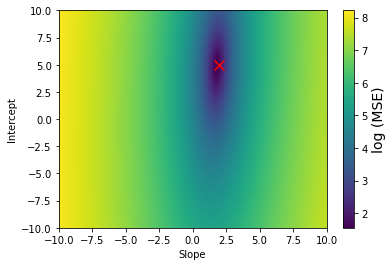

In [ ]:
X,Y,Z=[],[],[]
for slope in numpy.arange(-10, 10,.2):

    for intercept in numpy.arange(-10, 10,.2):
        Y.append(intercept)
        X.append(slope)
        Z.append(mse_cost.evaluate([slope,intercept]))
sc=pyplot.scatter(X,Y, c=numpy.log(Z))
pyplot.scatter(2, 5, marker='x',s=100, c='r')
cbar=pyplot.colorbar(sc)
cbar.set_label('log (MSE)', size=14)
pyplot.ylabel('Intercept')
pyplot.xlabel('Slope')
pyplot.xlim(-10,10)
pyplot.ylim(-10,10)

### A cost function for variational inference

Variational inference is an approximate approach to estimating the posterior distribution in Bayesian statistics. Rather than compute the posterior exactly (which is possible in only a limited set of simple models) or draw samples from the posterior using a Monte Carlo procedure (which is often preferable and often easily accomplished with [Stan]() or [PyMC3]()), variational inference seeks to identify a reasonable approximation of the posterior. This reframes inference as an optimization problem

$$ELBO(\theta, X) = \int_\zeta [ log P(\zeta, X) - log Q(\zeta; \mu, \sigma) ]$$

The integral is often avoided through the use of Monte Carlo simulations

$$z \sim Normal (0,1)$$
$$\zeta = \mu + z \sigma$$
$$ELBO(\theta, X) = log P(\zeta, X) - log Q(\zeta; \mu, \sigma) $$

When more typical stochastic gradient descent is employed, the gradient is usually evaluated analytically or through automatic differentiation *given a particular value of z* which drawn from a unit normal distribution of iteration of gradient descent. 

In general, optimizing this function based on exact gradient computations would be preferable (e.g. with PyMC3 or JAX), but if computing the evidence term ($log P (\zeta,X)$) requires simulations, the exact gradients will not be available. The noise in the objective function now comes from two sources:
1. The replacing the integral with Monte Carlo sampling
2. Using simulations to estimate the model's likelihood.




In [ ]:
norm_froz=scipy.stats.norm([0]*10,[1]*10)
norm_froz.rvs()

array([-0.30794448,  1.38911643, -0.86153109,  0.59804218, -0.43774877,
       -0.30468538,  0.2646122 ,  0.63004664, -1.01422891, -0.47949356])

In [ ]:


class ELBO(ModelBase):
    def __init__(self, evidence, data, param_num, log=True, update_rvs=True):
        self.cost=evidence
        self.data=data
        self.param_num=param_num
        self.update_rvs=True
        self.RV=scipy.stats.norm([0.]*param_num,[1.]*param_num)
        self.z=self.RV.rvs()
        self.log=log
        
    def evaluate(self, theta):
        mu=theta[:self.param_num]
        sd=2.**theta[self.param_num:]

        eps=mu+self.z*(sd)

        p=self.cost(eps, self.data)
        q=scipy.stats.norm.logpdf(eps, mu,sd).sum()
        if self.log==True:
            return numpy.log10(-(p-q))
        else:
            return -(p-q)
#     def up

In [ ]:
elbo=ELBO(MSE, data,10)

In [ ]:
elbo.sample_rvs()

In [ ]:
elbo.update_rvs

True